In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d landlord/handwriting-recognition



Dataset URL: https://www.kaggle.com/datasets/landlord/handwriting-recognition
License(s): CC0-1.0


In [3]:
!unzip /content/handwriting-recognition.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_v2/validation/VALIDATION_5003.jpg  
  inflating: validation_v2/validation/VALIDATION_5004.jpg  
  inflating: validation_v2/validation/VALIDATION_5005.jpg  
  inflating: validation_v2/validation/VALIDATION_5006.jpg  
  inflating: validation_v2/validation/VALIDATION_5007.jpg  
  inflating: validation_v2/validation/VALIDATION_5008.jpg  
  inflating: validation_v2/validation/VALIDATION_5009.jpg  
  inflating: validation_v2/validation/VALIDATION_5010.jpg  
  inflating: validation_v2/validation/VALIDATION_5011.jpg  
  inflating: validation_v2/validation/VALIDATION_5012.jpg  
  inflating: validation_v2/validation/VALIDATION_5013.jpg  
  inflating: validation_v2/validation/VALIDATION_5014.jpg  
  inflating: validation_v2/validation/VALIDATION_5015.jpg  
  inflating: validation_v2/validation/VALIDATION_5016.jpg  
  inflating: validation_v2/validation/VALIDATION_5017.jpg  
  inflating: validation_v2/validation/VALIDATION_

In [4]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

In [5]:
train_df = pd.read_csv('/content/written_name_train_v2.csv')
print(train_df.head())

          FILENAME   IDENTITY
0  TRAIN_00001.jpg  BALTHAZAR
1  TRAIN_00002.jpg      SIMON
2  TRAIN_00003.jpg      BENES
3  TRAIN_00004.jpg    LA LOVE
4  TRAIN_00005.jpg     DAPHNE


In [6]:


def preprocess_image(path, img_size=(128, 32)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, img_size)
    _, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)
    img = img.astype(np.float32) / 255.0
    return img


In [7]:
class HandwrittenNameDataset(Dataset):
    def __init__(self, csv_path, img_dir, img_size=(128, 32)):
        self.data = pd.read_csv(csv_path)

        # Clean data
        self.data.dropna(subset=['FILENAME', 'IDENTITY'], inplace=True)
        self.data = self.data[self.data['IDENTITY'].str.upper() != 'UNREADABLE']
        self.data = self.data[self.data['IDENTITY'].str.strip() != '']
        self.data.reset_index(drop=True, inplace=True)

        self.img_dir = img_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['FILENAME'])
        img = preprocess_image(img_path, self.img_size)
        label = row['IDENTITY'].strip().lower()
        img_tensor = torch.tensor(img).unsqueeze(0)  # (1, H, W)
        return img_tensor, label


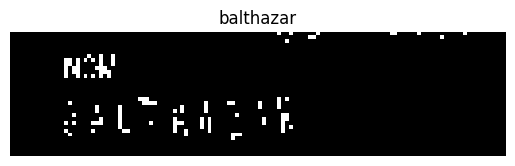

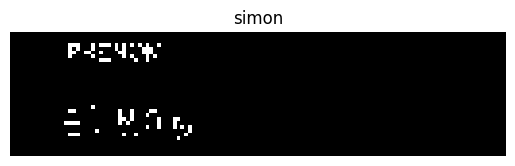

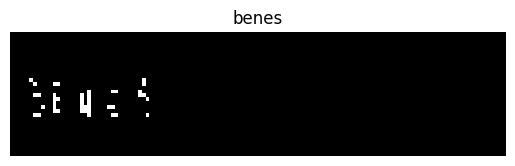

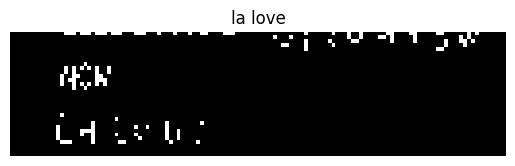

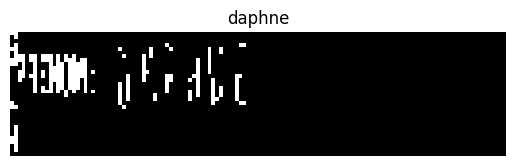

In [8]:
dataset = HandwrittenNameDataset('/content/written_name_train_v2.csv', '/content/train_v2/train')

import matplotlib.pyplot as plt

for i in range(5):
    img, label = dataset[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(label)
    plt.axis('off')
    plt.show()


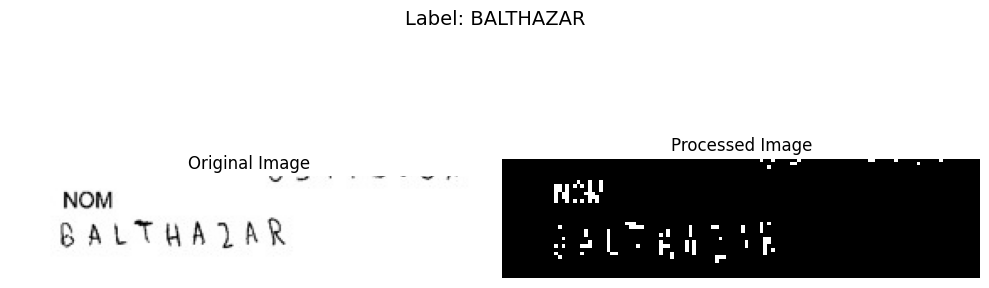

In [9]:
import matplotlib.pyplot as plt

def show_original_and_processed(dataset, index):
    row = dataset.data.iloc[index]
    img_path = os.path.join(dataset.img_dir, row['FILENAME'])

    # Load original
    original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    # Load processed
    processed_img = preprocess_image(img_path)

    # Plot side by side
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(processed_img, cmap='gray')
    plt.title('Processed Image')
    plt.axis('off')

    plt.suptitle(f"Label: {row['IDENTITY'].strip()}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Example usage:
show_original_and_processed(dataset, index=0)


In [10]:
from collections import defaultdict

# Build vocabulary from the dataset
def build_vocab(dataset):
    charset = set()
    for _, label in dataset:
        charset.update(label)
    charset = sorted(list(charset))  # e.g., [' ', 'a', 'b', ..., 'z']

    char_to_idx = {char: idx + 1 for idx, char in enumerate(charset)}  # start at 1
    char_to_idx['<blank>'] = 0  # CTC requires blank token at index 0
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}

    return char_to_idx, idx_to_char

# Build mappings
char_to_idx, idx_to_char = build_vocab(dataset)

print("Total characters:", len(char_to_idx))
print("Example mapping:", list(char_to_idx.items())[:10])


Total characters: 31
Example mapping: [(' ', 1), ("'", 2), ('-', 3), ('`', 4), ('a', 5), ('b', 6), ('c', 7), ('d', 8), ('e', 9), ('f', 10)]


In [11]:
# Convert string to list of indices
def encode_label(label, char_to_idx):
    return [char_to_idx[char] for char in label if char in char_to_idx]

# Convert list of indices back to string
def decode_label(indices, idx_to_char):
    return ''.join([idx_to_char[idx] for idx in indices if idx in idx_to_char])


In [12]:
sample_label = "daphne"
encoded = encode_label(sample_label, char_to_idx)
decoded = decode_label(encoded, idx_to_char)

print("Original:", sample_label)
print("Encoded:", encoded)
print("Decoded:", decoded)


Original: daphne
Encoded: [8, 5, 20, 12, 18, 9]
Decoded: daphne


In [13]:
class HandwrittenNameDatasetEncode(Dataset):
    def __init__(self, csv_path, img_dir, img_size=(128, 32)):
        self.data = pd.read_csv(csv_path)

        # Clean data
        self.data.dropna(subset=['FILENAME', 'IDENTITY'], inplace=True)
        self.data = self.data[self.data['IDENTITY'].str.upper() != 'UNREADABLE']
        self.data = self.data[self.data['IDENTITY'].str.strip() != '']
        self.data.reset_index(drop=True, inplace=True)

        self.img_dir = img_dir
        self.img_size = img_size

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_dir, row['FILENAME'])
        img = preprocess_image(img_path, self.img_size)
        label_str = row['IDENTITY'].strip().lower()
        label_encoded = encode_label(label_str, char_to_idx)

        img_tensor = torch.tensor(img).unsqueeze(0)  # (1, H, W)
        label_tensor = torch.tensor(label_encoded, dtype=torch.long)

        return img_tensor, label_tensor, label_str  # (image, label_encoded, label_str)

Model Setup

In [14]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, img_height, num_classes):
        super(CRNN, self).__init__()

        # 1. CNN: Extract visual features
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # → (64, H, W)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # → (64, H/2, W/2)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # → (128, H/2, W/2)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                          # → (128, H/4, W/4)

            nn.Conv2d(128, 256, kernel_size=3, padding=1), # → (256, H/4, W/4)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),  # Reduce height only → (256, H/8, W/4)

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d((2, 1)),  # → (512, H/16, W/4)
        )

        # 2. RNN: Bidirectional LSTM
        self.rnn = nn.LSTM(input_size=512 * (img_height // 16), hidden_size=256,
                           num_layers=2, bidirectional=True)

        # 3. Linear classifier
        self.fc = nn.Linear(512, num_classes)  # 256x2 = 512 due to bidirectional

    def forward(self, x):
        x = self.cnn(x)  # [B, C, H, W]
        b, c, h, w = x.size()

        # Collapse height dimension and permute to [T, B, Input]
        x = x.permute(3, 0, 1, 2)  # [W, B, C, H]
        x = x.view(w, b, c * h)    # [W, B, C*H]

        # RNN + Linear
        x, _ = self.rnn(x)         # [W, B, 512]
        x = self.fc(x)             # [W, B, num_classes]

        return x  # logits for each time step


In [15]:
ctc_loss = nn.CTCLoss(blank=0)  # <blank> is index 0


In [16]:
img_height = 32
num_classes = len(char_to_idx)  # total characters + <blank>
model = CRNN(img_height, num_classes)


In [17]:
def collate_fn(batch):
    images, labels, raw_labels = zip(*batch)

    images = torch.stack(images)  # [B, 1, H, W]

    label_lengths = [len(label) for label in labels]
    target = torch.cat(labels)  # Flattened target
    input_lengths = torch.full(size=(len(images),), fill_value=images.shape[-1] // 4, dtype=torch.long)

    return images, target, input_lengths, torch.tensor(label_lengths), raw_labels


In [18]:
from torch.utils.data import DataLoader

train_dataset = HandwrittenNameDatasetEncode(
    csv_path='/content/written_name_train_v2.csv',
    img_dir='/content/train_v2/train'
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CRNN(img_height=32, num_classes=len(char_to_idx)).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # lowered LR
ctc_loss = nn.CTCLoss(blank=0, zero_infinity=True)

for epoch in range(10):
    model.train()
    total_loss = 0

    for batch_idx, batch in enumerate(train_loader):
        images, targets, input_lengths, target_lengths, _ = batch
        images = images.to(device)
        targets = targets.to(device)
        input_lengths = input_lengths.to(device)
        target_lengths = target_lengths.to(device)

        # 🔍 Debug 1: Check image values
        print(f"\n📦 Batch {batch_idx + 1}")
        print("Image min/max:", images.min().item(), images.max().item())
        print("Input lengths:", input_lengths.tolist())
        print("Target lengths:", target_lengths.tolist())
        print("Any empty targets?", any(l == 0 for l in target_lengths.tolist()))

        try:
            preds = model(images)  # [T, B, C]
        except Exception as e:
            print("🔥 Model forward error:", str(e))
            break

        # 🔍 Debug 2: Check model output
        print("Model output shape (T, B, C):", preds.shape)
        print("Any NaNs in model output?", torch.isnan(preds).any().item())
        print("Output max:", preds.max().item(), "min:", preds.min().item())

        try:
            log_probs = preds.log_softmax(2)
            loss = ctc_loss(log_probs, targets, input_lengths, target_lengths)
        except Exception as e:
            print("🔥 CTC Loss error:", str(e))
            break

        if torch.isnan(loss):
            print("🚨 Loss is NaN! Skipping this batch.")
            continue

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5)
        optimizer.step()

        total_loss += loss.item()
        print("✅ Batch loss:", loss.item())

    print(f"\n🔁 Epoch {epoch + 1} finished — Total loss: {total_loss:.4f}")



Streaming output truncated to the last 5000 lines.
Image min/max: 0.0 1.0
Input lengths: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Target lengths: [9, 8, 8, 10, 6, 5, 5, 5, 7, 11, 10, 5, 4, 7, 5, 6, 5, 8, 7, 7, 7, 7, 5, 7, 8, 5, 7, 8, 8, 4, 7, 11]
Any empty targets? False
Model output shape (T, B, C): torch.Size([32, 32, 31])
Any NaNs in model output? False
Output max: 19.763200759887695 min: -22.467744827270508
✅ Batch loss: 0.42188993096351624

📦 Batch 9824
Image min/max: 0.0 1.0
Input lengths: [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32]
Target lengths: [8, 4, 9, 7, 9, 13, 9, 9, 5, 6, 8, 4, 6, 5, 4, 9, 6, 6, 8, 6, 4, 7, 6, 5, 16, 10, 7, 8, 6, 8, 6, 6]
Any empty targets? False
Model output shape (T, B, C): torch.Size([32, 32, 31])
Any NaNs in model output? False
Output max: 19.94280242919922 min: -23.900976181030273

In [20]:
def ctc_greedy_decoder(output, idx_to_char):
    # output: [T, B, C] → log-probabilities from the model
    out_softmax = output.softmax(2)  # [T, B, C]
    max_probs = torch.argmax(out_softmax, dim=2)  # [T, B]

    results = []
    for b in range(max_probs.shape[1]):
        seq = max_probs[:, b].tolist()
        decoded = []
        prev = None
        for idx in seq:
            if idx != prev and idx != 0:  # skip repeats and <blank>
                decoded.append(idx_to_char.get(idx, ''))
            prev = idx
        results.append(''.join(decoded))

    return results


In [21]:
model.eval()
with torch.no_grad():
    for batch in train_loader:
        images, _, _, _, raw_labels = batch
        images = images.to(device)
        preds = model(images)  # [T, B, C]

        decoded_preds = ctc_greedy_decoder(preds.cpu(), idx_to_char)

        for true_label, pred_label in zip(raw_labels, decoded_preds):
            print(f"🔹 Ground Truth: {true_label}\n🔸 Prediction:   {pred_label}\n")
        break  # remove this to loop over all


🔹 Ground Truth: hadu
🔸 Prediction:   hadu

🔹 Ground Truth: zhu
🔸 Prediction:   zhu

🔹 Ground Truth: chloe
🔸 Prediction:   chloe

🔹 Ground Truth: bourdon
🔸 Prediction:   bourdon

🔹 Ground Truth: rinuccini
🔸 Prediction:   rinucleni

🔹 Ground Truth: julie
🔸 Prediction:   julie

🔹 Ground Truth: reucherain
🔸 Prediction:   peucherain

🔹 Ground Truth: bretaire
🔸 Prediction:   bretaire

🔹 Ground Truth: aaron
🔸 Prediction:   mabon

🔹 Ground Truth: hyppian
🔸 Prediction:   junan

🔹 Ground Truth: thomas
🔸 Prediction:   thomas

🔹 Ground Truth: yanis
🔸 Prediction:   yanis

🔹 Ground Truth: courmont
🔸 Prediction:   courmont

🔹 Ground Truth: arnal
🔸 Prediction:   arnal

🔹 Ground Truth: lemoine
🔸 Prediction:   lemoine

🔹 Ground Truth: diogo
🔸 Prediction:   diogo

🔹 Ground Truth: degioanni
🔸 Prediction:   degisanni

🔹 Ground Truth: emilien
🔸 Prediction:   eailien

🔹 Ground Truth: christophe
🔸 Prediction:   christophe

🔹 Ground Truth: lebretom
🔸 Prediction:   lebreton

🔹 Ground Truth: ombeline
🔸 Predictio

In [24]:
from difflib import SequenceMatcher

def char_accuracy(pred, target):
    return SequenceMatcher(None, pred, target).ratio()

model.eval()
exact_match_count = 0
total_samples = 0
total_char_accuracy = 0

with torch.no_grad():
    for batch in train_loader:
        images, _, _, _, raw_labels = batch
        images = images.to(device)
        preds = model(images)
        decoded_preds = ctc_greedy_decoder(preds.cpu(), idx_to_char)

        for true_label, pred_label in zip(raw_labels, decoded_preds):
            total_samples += 1
            if true_label == pred_label:
                exact_match_count += 1

            total_char_accuracy += char_accuracy(pred_label, true_label)

# Metrics
exact_match_accuracy = exact_match_count / total_samples * 100
average_char_accuracy = total_char_accuracy / total_samples * 100

print(f"\n✅ Final Evaluation:")
print(f"🔹 Exact Match Accuracy: {exact_match_accuracy:.2f}%")
print(f"🔸 Avg. Character-Level Accuracy: {average_char_accuracy:.2f}%")



✅ Final Evaluation:
🔹 Exact Match Accuracy: 60.55%
🔸 Avg. Character-Level Accuracy: 89.32%


In [25]:
import numpy as np
import editdistance

edit_distances = []
pred_lengths = []
true_lengths = []

for true_label, pred_label in zip(raw_labels, decoded_preds):
    d = editdistance.eval(true_label, pred_label)
    edit_distances.append(d)
    pred_lengths.append(len(pred_label))
    true_lengths.append(len(true_label))

avg_edit_distance = np.mean(edit_distances)
print(f"📝 Average Edit Distance: {avg_edit_distance:.2f}")


📝 Average Edit Distance: 0.68


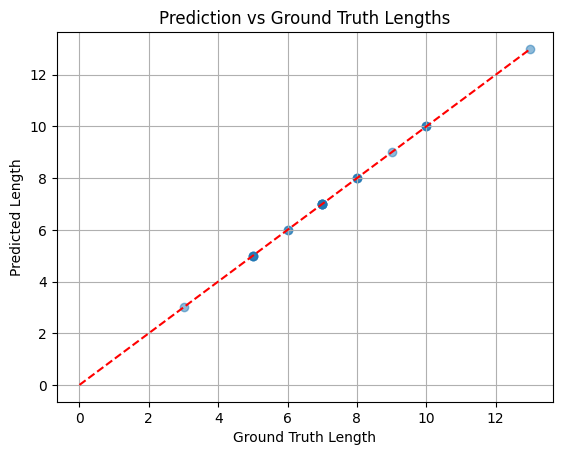

In [26]:
plt.scatter(true_lengths, pred_lengths, alpha=0.5)
plt.plot([0, max(true_lengths)], [0, max(true_lengths)], 'r--')  # identity line
plt.xlabel("Ground Truth Length")
plt.ylabel("Predicted Length")
plt.title("Prediction vs Ground Truth Lengths")
plt.grid(True)
plt.show()


In [27]:
sorted_examples = sorted(zip(raw_labels, decoded_preds, edit_distances), key=lambda x: -x[2])
print("\n❌ Worst Predictions:")
for i in range(5):  # top 5 worst
    true, pred, dist = sorted_examples[i]
    print(f"\n🔹 Ground Truth: {true}\n🔸 Prediction:   {pred}\n❗ Edit Distance: {dist}")



❌ Worst Predictions:

🔹 Ground Truth: ledrappier
🔸 Prediction:   lerrontier
❗ Edit Distance: 4

🔹 Ground Truth: rampnoux
🔸 Prediction:   samaraux
❗ Edit Distance: 4

🔹 Ground Truth: empty
🔸 Prediction:   hemot
❗ Edit Distance: 3

🔹 Ground Truth: cherifi
🔸 Prediction:   cherifz
❗ Edit Distance: 1

🔹 Ground Truth: samson
🔸 Prediction:   samlon
❗ Edit Distance: 1


In [ ]:
print("Input lengths:", input_lengths[:5].tolist())
print("Target lengths:", target_lengths[:5].tolist())
print("Any empty target?", any(l == 0 for l in target_lengths.tolist()))

In [ ]:
with torch.no_grad():
    print("Pred shape:", preds.shape)  # [T, B, C]
    print("Any NaNs in model output?", torch.isnan(preds).any().item())
    print("Max pred value:", preds.max().item())
    print("Min pred value:", preds.min().item())
